## Graph Neural Network Property Predictor


## Imports

In [1]:
# Main Imports
import torch
import random
import numpy as np

# Profiling
import cProfile
import pstats
from pstats import SortKey

# Import Local Files
from model import GNN
from utils.config import FEATURE_NAMES, RESIDUAL_G_FEATURES
import utils.data_utils as DataUtils
import utils.visualization as Visualization

c:\Users\Will\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Execution

In [2]:
# Profile the main training routine
# profiler = cProfile.Profile()
# profiler.enable()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# For reference
"""
GRAPH_METRICS = [
    "Density",
    "AvgClustering",
    "AvgPathLength",
    "DegreeAssortativity",
    "Transitivity",
    "ConnectedComponents",
    "MaxDegree",
    "MinDegree",
    "AvgDegree",
    "GlobalEfficiency"
]
"""

# Select target feature for analysis
target_feature = "GMinus_" + "AvgPathLength"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

# Generate different graphs for training and test to test generalization
print("Generating graphs...")
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=1000, edge_prob=0.2)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=1000, edge_prob=0.2)

print(f"Train graph: {len(G_train)} nodes, {G_train.number_of_edges()} edges")
print(f"Test graph: {len(G_test)} nodes, {G_test.number_of_edges()} edges")

print("\nProcessing graph data...")
train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

# Initialize Model
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
print(f"FEATURE_NAMES length: {len(FEATURE_NAMES)}")

# Make sure the dimensions match
if node_feature_dim != len(FEATURE_NAMES):
    print(f"Warning: Feature dimension mismatch! Expected {len(FEATURE_NAMES)}, got {node_feature_dim}")

model = GNN(node_feature_dim=len(FEATURE_NAMES))
# print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Train model
print("\nTraining model...")
losses, trained_model, feature_stats = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate elapsed time and profiling results
# profiler.disable()
# print("\nProfiling Results:")
# stats = pstats.Stats(profiler).sort_stats(SortKey.TIME)
# stats.print_stats(20)  # Show top 20 time-consuming functions



Generating graphs...
Train graph: 1000 nodes, 99851 edges
Test graph: 1000 nodes, 99588 edges

Processing graph data...

Initializing model...
Node feature dimension: 11
FEATURE_NAMES length: 11

Training model...

Training Progress:
Epoch 0: Train Loss = 1.6601e-02, Test Loss = 1.0467e-02
Epoch 1: Train Loss = 9.7165e-03, Test Loss = 6.2526e-03
Epoch 2: Train Loss = 5.7427e-03, Test Loss = 4.6878e-03
Epoch 3: Train Loss = 4.4233e-03, Test Loss = 5.0842e-03


c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: Train Loss = 5.0444e-03, Test Loss = 6.2615e-03
Epoch 5: Train Loss = 6.3876e-03, Test Loss = 7.1475e-03
Epoch 6: Train Loss = 7.3627e-03, Test Loss = 7.2988e-03
Epoch 7: Train Loss = 7.5320e-03, Test Loss = 6.8112e-03
Epoch 8: Train Loss = 7.0007e-03, Test Loss = 6.0101e-03
Epoch 9: Train Loss = 6.1146e-03, Test Loss = 5.2373e-03
Epoch 10: Train Loss = 5.2333e-03, Test Loss = 4.7413e-03
Epoch 11: Train Loss = 4.6207e-03, Test Loss = 4.6304e-03
Epoch 12: Train Loss = 4.3977e-03, Test Loss = 4.8641e-03
Epoch 13: Train Loss = 4.5337e-03, Test Loss = 5.2849e-03
Epoch 14: Train Loss = 4.8785e-03, Test Loss = 5.6910e-03
Epoch 15: Train Loss = 5.2344e-03, Test Loss = 5.9202e-03
Epoch 16: Train Loss = 5.4399e-03, Test Loss = 5.9044e-03
Epoch 17: Train Loss = 5.4256e-03, Test Loss = 5.6741e-03
Epoch 18: Train Loss = 5.2191e-03, Test Loss = 5.3255e-03
Epoch 19: Train Loss = 4.9125e-03, Test Loss = 4.9746e-03
Epoch 20: Train Loss = 4.6170e-03, Test Loss = 4.7159e-03
Epoch 21: Train Loss

## Visualization

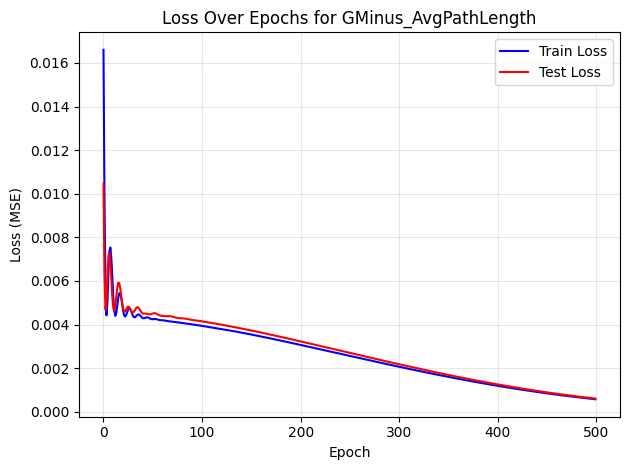


Model Predictions Analysis:
Using 500 sampled target values from training
Average prediction: 0.589691
Average actual value: 0.594973
Std dev of actual values: 0.000000
Average absolute error: 0.005282
Standard deviation of predictions: 0.009150


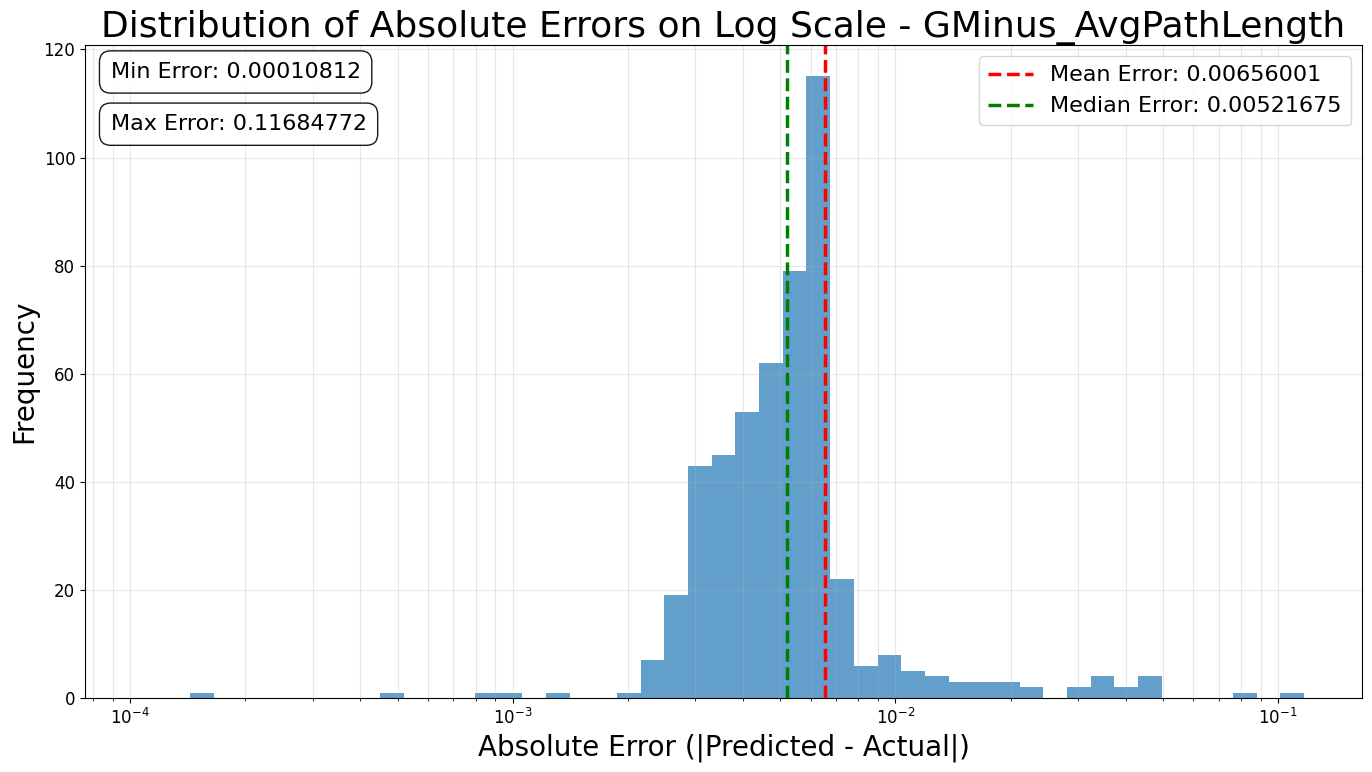


=== Node Feature Statistics ===
                 Feature     Mean      Min      Max  Std Dev  Variance  All Identical
      Node_Metric_Degree 0.828639 0.668050 1.000000 0.051099  0.002611          False
  Node_Metric_Clustering 0.200763 0.121053 0.294737 0.028913  0.000836          False
 Node_Metric_NeighborDeg 0.831785 0.818519 0.841045 0.003006  0.000009          False
 Node_Metric_Betweenness 0.008064 0.000000 0.025144 0.003778  0.000014          False
   Node_Metric_Closeness 5.163584 4.340249 6.000000 0.264479  0.069949          False
    Node_Metric_PageRank 0.010000 0.008324 0.011714 0.000524  0.000000          False
  Node_Metric_CoreNumber 0.999547 0.936047 1.000000 0.004002  0.000016          False
    Node_Metric_LocalEff 0.319861 0.314954 0.324653 0.001622  0.000003          False
 Node_Metric_Eigenvector 0.315624 0.255564 0.382617 0.019528  0.000381          False
Node_Metric_LocalDensity 0.207773 0.199348 0.216305 0.002721  0.000007          False
  Node_Metric_IsSelec

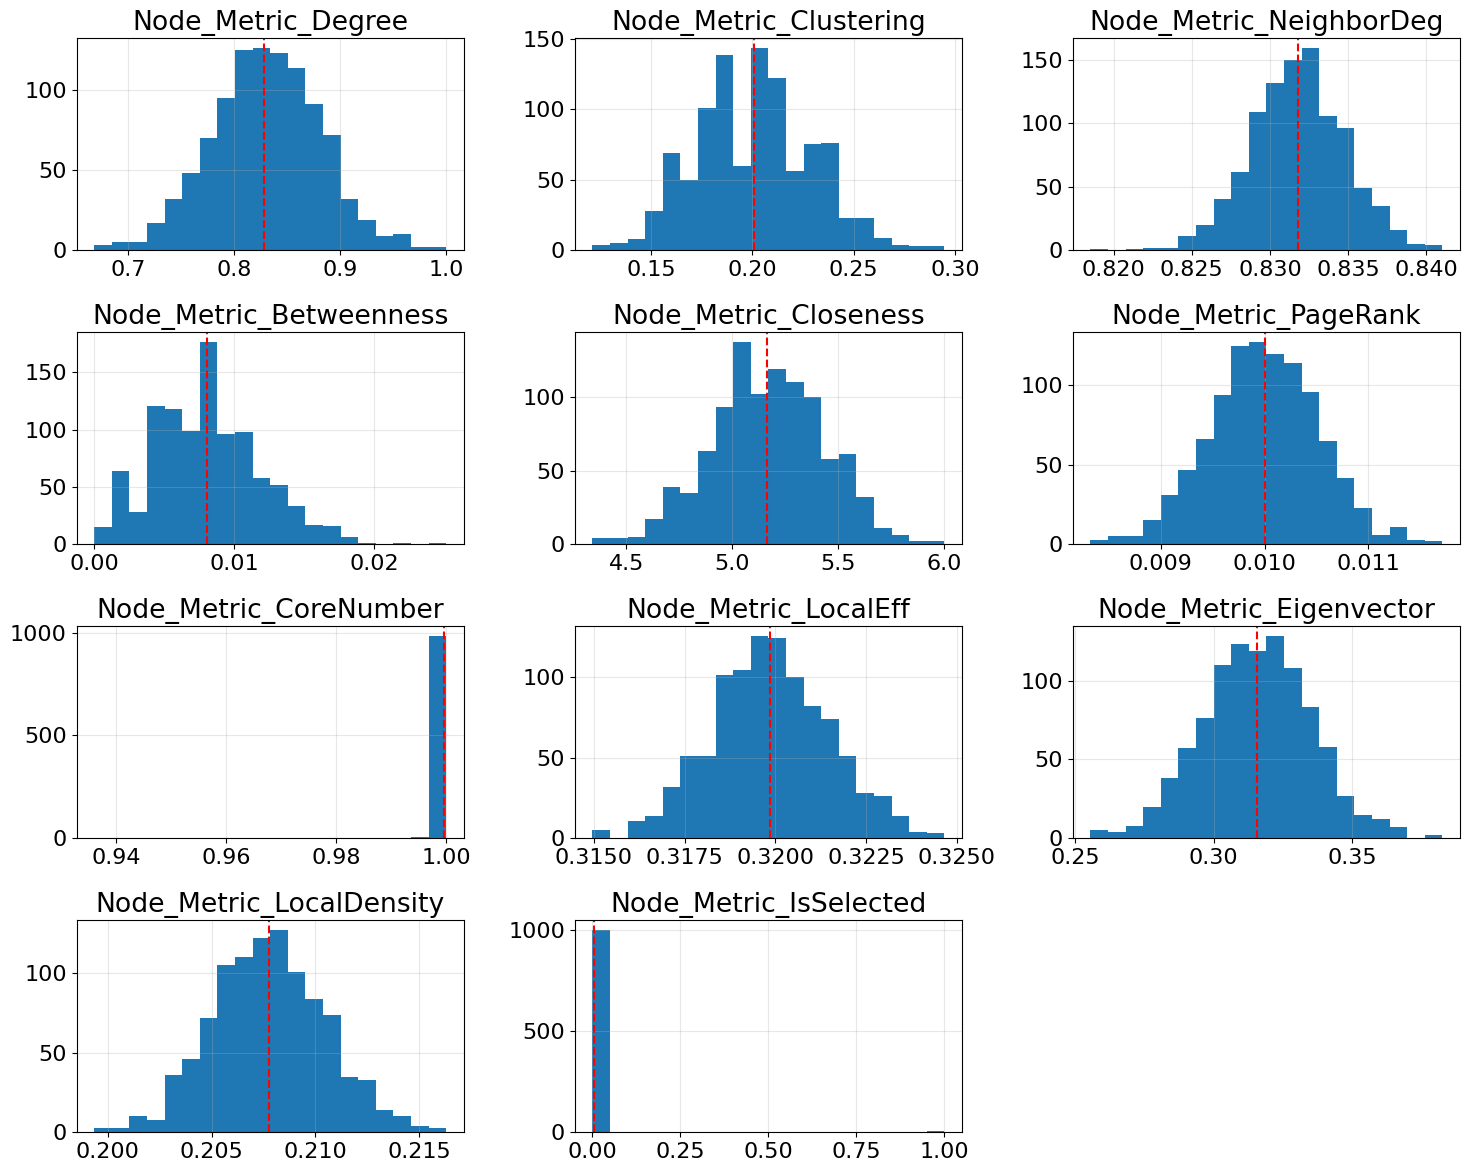


Performing PCA on node features...
Using raw node features
Sampling 500 nodes from 1000 total

PCA Explained Variance:
  PC1: 98.27% (Cumulative: 98.27%)
  PC2: 1.07% (Cumulative: 99.34%)
  PC3: 0.60% (Cumulative: 99.93%)

Feature Contributions to Top Components:
                               PC1       PC2
Node_Metric_Closeness     0.981853  0.002628
Node_Metric_Degree        0.177161 -0.008013
Node_Metric_Eigenvector   0.067409 -0.000595
Node_Metric_CoreNumber    0.004392 -0.006911
Node_Metric_Betweenness   0.002635 -0.008899
Node_Metric_LocalDensity -0.002132  0.006925
Node_Metric_PageRank      0.001819 -0.000146
Node_Metric_Clustering   -0.001050  0.999847
Node_Metric_LocalEff     -0.000265  0.004171
Node_Metric_NeighborDeg  -0.000170  0.006505


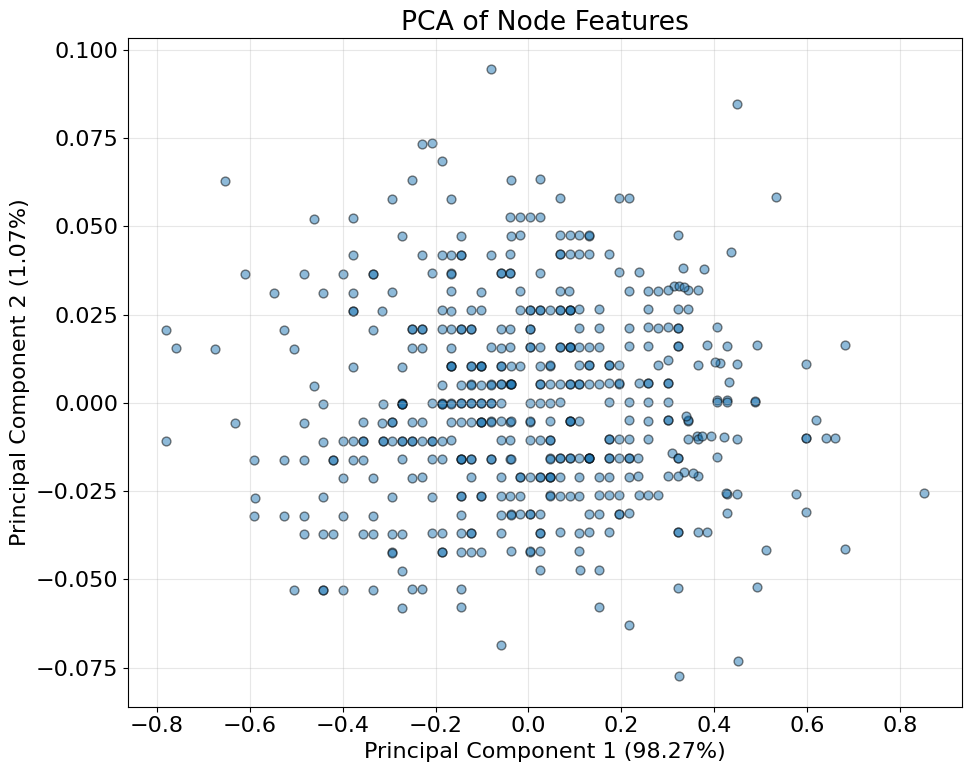

In [3]:
# Do visualization
Visualization.visualize_results(losses, trained_model, test_data, target_feature, feature_stats)
# Visualization.visualize_feature_redundancy(feature_stats)
feature_stats_df = Visualization.visualize_feature_statistics(train_data, show_histograms=True)
# Visualization.visualize_feature_pairs(train_data, num_pairs=15, prioritize_variance=True, use_node_features=True)
pca, components = Visualization.visualize_pca(train_data, n_components=3, use_node_features=True)